In [1]:
%load_ext autoreload
%autoreload 2
import sys
if "../" not in sys.path:
    sys.path.append("../")
import os
import json
import time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from itertools import product

from volterra_hawkes.iVi.iVi_hawkes import IVIHawkesProcess
from volterra_hawkes.kernel.kernels import *
from volterra_hawkes.utility.visualisation import Experiment, get_N_U_sample, get_arrivals_sample, plot_trajectories, \
    plot_marginal_laws, poisson_jumps_test, plot_cf_convergence

from simulation.monte_carlo import MonteCarlo

plt.style.use('seaborn-v0_8-deep')
plt.style.use('default')  # 'default' or any other light theme like 'seaborn-white'

color_cycle = ["#B56246", "#579F40", "#9A46B5", "#4699B5", "#B54662", "#D4A017", "#5b6c64", "#71074E", "#0033A0"]
plt.rcParams["figure.figsize"]        = ((1 + np.sqrt(5)) / 2 * 5, 5)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True
plt.rcParams['axes.prop_cycle']       = matplotlib.cycler(color=color_cycle)

## Experiment choice: Visualisation of the trajectories

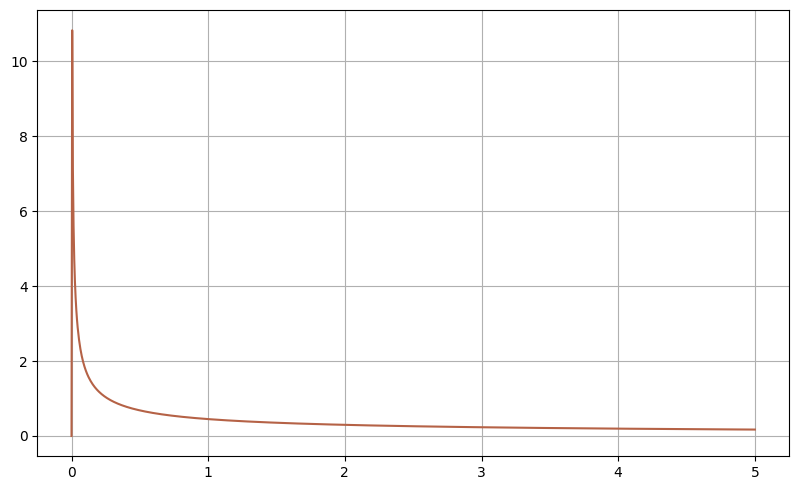

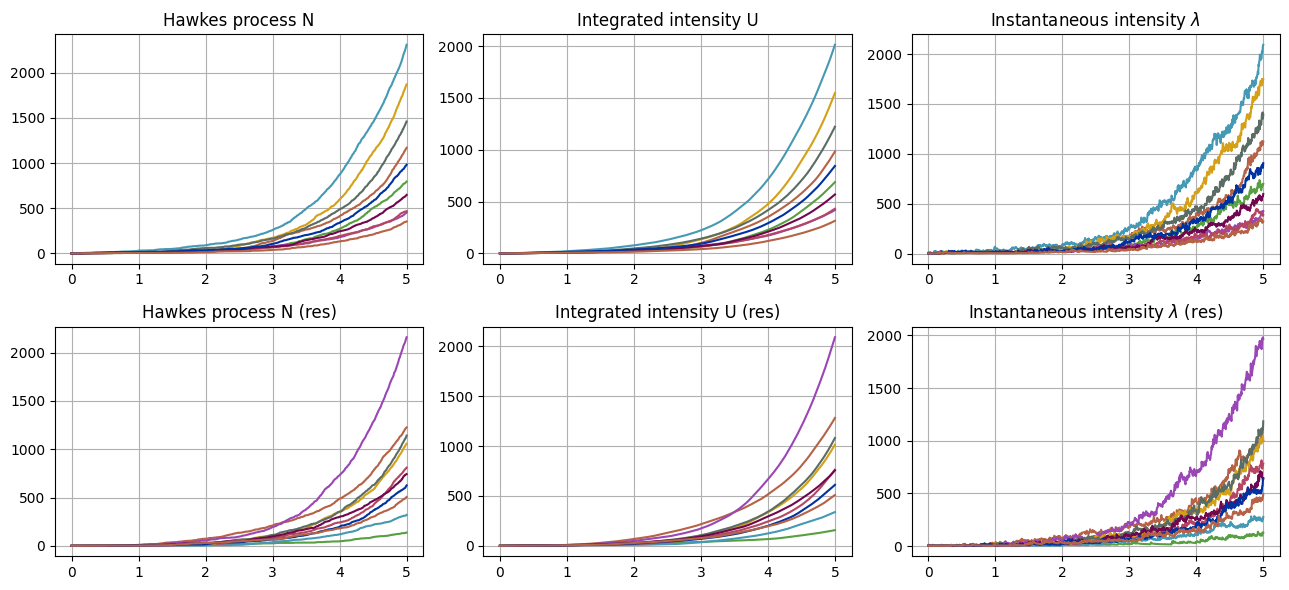

In [2]:
# mu = 3
# H = 0.3
# lam = 1
# c = 2
# alpha = 2

# T = 1
# n_steps = 1000

# rng = np.random.default_rng(seed=42)

#K = ConstantKernel(c=3)
#K = FractionalKernel(H=H, c=c)
#K = ExponentialKernel(c=c, lam=lam)
#K = GammaKernel(lam=lam, alpha=alpha, c=lam**alpha)


e = Experiment(
    T=5,
    n_steps = 1000,
    kernel = FractionalKernel(H=-0.1, c=1),
    mu=3
)

# e = Experiment(
#     T=5,
#     n_steps = 1000,
#     kernel = ExponentialKernel(lam=5, c=6),
#     mu=3
# )

# lam = 5
# alpha = 4
# t0 = (alpha - 1) / lam
# gamma_kernel = GammaKernel(lam=lam, alpha=alpha, c=lam**alpha * 2)
# e = Experiment(
#     T=4,
#     n_steps = 100,
#     kernel = gamma_kernel,
#     decreasing_kernel=lambda t: gamma_kernel(t) * (t > t0) + gamma_kernel(t0) * (t <= t0),
#     mu=3
# )

# e = Experiment(
#     T=5,
#     n_steps = 1000,
#     kernel = ConstantKernel(c=0.1),
#     mu=3
# )

plt.plot(e.t_grid, e.kernel(e.t_grid))
if e.decreasing_kernel is not None:
    plt.plot(e.t_grid, e.decreasing_kernel(e.t_grid))
plot_trajectories(e)


In [6]:
lam_gamma = 5
alpha_gamma = 4
t0_gamma = (alpha_gamma - 1) / lam_gamma
gamma_kernel = GammaKernel(lam=lam_gamma, alpha=alpha_gamma, c=lam_gamma**alpha_gamma * 2)

lam_gamma_2 = 20
alpha_gamma_2 = 4
t0_gamma_2 = (alpha_gamma_2 - 1) / lam_gamma_2
gamma_kernel_2 = GammaKernel(lam=lam_gamma_2, alpha=alpha_gamma_2, c=lam_gamma_2**alpha_gamma_2)

experiments_list = [
    Experiment(
    T=1,
    n_steps = 1000,
    kernel = gamma_kernel_2,
    mu=10,
    decreasing_kernel=lambda t: gamma_kernel_2(t) * (t > t0_gamma_2) + gamma_kernel_2(t0_gamma_2) * (t <= t0_gamma_2),
    ),
    Experiment(
    T=5,
    n_steps = 1000,
    kernel = FractionalKernel(H=0.3, c=1),
    mu=3
    ),
    Experiment(
    T=5,
    n_steps = 1000,
    kernel = FractionalKernel(H=0., c=1),
    mu=3
    ),
    Experiment(
    T=5,
    n_steps = 1000,
    kernel = FractionalKernel(H=0.1, c=0.5),
    mu=3
    ),
    Experiment(
    T=5,
    n_steps = 1000,
    kernel = FractionalKernel(H=0.1, c=1),
    mu=3
    ),
    Experiment(
    T=5,
    n_steps = 1000,
    kernel = FractionalKernel(H=-0.1, c=1),
    mu=3
    ),
    Experiment(
    T=4,
    n_steps = 100,
    kernel = gamma_kernel,
    mu=3,
    decreasing_kernel=lambda t: gamma_kernel(t) * (t > t0_gamma) + gamma_kernel(t0_gamma) * (t <= t0_gamma),
    ),
    Experiment(
    T=5,
    n_steps = 1000,
    kernel = ConstantKernel(c=1),
    mu=3
    ),
    Experiment(
    T=5,
    n_steps = 1000,
    kernel = ConstantKernel(c=0.1),
    mu=3
    ),
    Experiment(
    T=5,
    n_steps = 1000,
    kernel = ExponentialKernel(lam=5, c=5),
    mu=3
    ),
    Experiment(
    T=5,
    n_steps = 1000,
    kernel = ExponentialKernel(lam=1, c=1),
    mu=3
    ),
    Experiment(
    T=5,
    n_steps = 1000,
    kernel = ExponentialKernel(lam=5, c=6),
    mu=3
    )
]

In [7]:
def run_test0(e, path_experiment, experiment_results):
    # test 0: plot the kernel and sample trajectories
    fig, ax = plt.subplots()
    ax.plot(e.t_grid, e.kernel(e.t_grid))
    fig.savefig(path_experiment + "kernel.pdf", format="pdf", bbox_inches="tight", transparent=True)

    plot_trajectories(e, path=path_experiment + "sample_trajectories.pdf")


def run_test1(e, path_experiment, experiment_results):
    # test 1: compute E[N_T]
    rng = np.random.default_rng(seed=42)
    ivi_hawkes = IVIHawkesProcess(kernel=e.kernel, g0_bar=e.g0_bar, rng=rng, g0=e.g0)
    expected_U = ivi_hawkes.U_mean(t_grid=np.linspace(e.t_grid[0], e.t_grid[-1], 1000))
    experiment_results["mean_N_T"] = expected_U[-1]
    print("Mean:", experiment_results["mean_N_T"])


def run_test2(e, path_experiment, experiment_results, samples_non_ivi):
    # test 2: marginal laws
    samples = {method: samples_non_ivi[method] for method in samples_non_ivi.keys()}
    print("Computing iVi samples...")
    n_steps_arr = [10, 50, 100, 1000]
    ivi_methods = ["iVi", "Res iVi"]
    n_paths = 10_000
    for n_steps in n_steps_arr:
        nan_flag = False
        print("n_steps =", n_steps)
        for method in ivi_methods:
            try:
                samples[method] = get_N_U_sample(experiment=e.change_n_steps(n_steps), method=method,
                                                 n_paths=n_paths, return_counters=True)
            except Exception as ex:
                print("Exception occured:", ex)
                samples[method] = (np.array([[np.nan]]), np.array([[np.nan]]))
                nan_flag = True
        if nan_flag:
            continue
        experiment_results["U_p_values_" + str(n_steps)] = plot_marginal_laws(samples, "U", path=path_experiment + "marginal_laws_U_" + str(n_steps) + ".pdf")
        experiment_results["N_p_values_" + str(n_steps)] = plot_marginal_laws(samples, "N", path=path_experiment + "marginal_laws_N_" + str(n_steps) + ".pdf")


def run_test3(e, path_experiment, experiment_results, samples_non_ivi):
    # test 3: convergence of the CF
    print("Computing iVi samples...")
    methods_ivi = ["iVi", "Res iVi"]
    n_steps_arr = [20, 35, 50, 65, 80, 100, 200, 350, 500, 750, 1000]
    batch_size = 100_000
    n_batch = 10
    n_paths = n_batch * batch_size
    experiments = [e.change_n_steps(n_steps=n_steps) for n_steps in n_steps_arr]

    w = -1 / experiment_results["mean_N_T"]
    fun = lambda x: np.exp(w * x)
    cf_ref = {}

    for mode in ["U", "N"]:
        rng = np.random.default_rng(seed=42)
        ivi = IVIHawkesProcess(kernel=experiments[-1].kernel, g0_bar=experiments[-1].g0_bar, rng=rng,
                               g0=experiments[-1].g0, resolvent_flag=False)
        cf_ref[mode] = ivi.characteristic_function(T=experiments[-1].T, w=w, n_steps=10000, mode=mode)


    experiments = [e.change_n_steps(n_steps=n_steps) for n_steps in n_steps_arr]
    mc_samples = dict()

    errors_ivi = {"U": {m: [] for m in methods_ivi}, "N": {m: [] for m in methods_ivi}}
    for method, experiment in product(methods_ivi, experiments):
        print(method, experiment.n_steps)
        rng = np.random.default_rng(seed=42)
        time_ivi = time.time()
        for _ in range(n_batch):
            sample = get_N_U_sample(experiment=experiment, method=method, n_paths=batch_size, rng=rng, return_counters=True)
            for mode in ["U", "N"]:
                idx = 1 if mode == "U" else 0
                if (method, experiment.n_steps, mode) not in mc_samples:
                    mc_samples[(method, experiment.n_steps, mode)] = MonteCarlo(batch=fun(sample[idx][:, -1]), confidence_level=0.95)
                else:
                    mc_samples[(method, experiment.n_steps, mode)].add_batch(batch=fun(sample[idx][:, -1]))
        time_ivi = time.time() - time_ivi
        experiment_results["time_" + method + "_" + str(experiment.n_steps)] = time_ivi
        for mode in ["U", "N"]:
            errors_ivi[mode][method].append(np.abs(cf_ref[mode] - mc_samples[(method, experiment.n_steps, mode)].mean))

    plot_cf_convergence(experiments=experiments, n_paths=n_paths, n_steps_arr=n_steps_arr, samples_non_ivi=samples_non_ivi,
                        errors_ivi=errors_ivi, path_experiment=path_experiment, fun=fun)


def run_test4(e, path_experiment, experiment_results):
    # test 4: sampling arrivals
    methods = ["Population", "Ogata", "iVi", "Res iVi"]
    n_steps_arr = [10, 50, 100, 1000]
    for n_steps in n_steps_arr:
        rng = np.random.default_rng(seed=42)
        experiment_results["arriavals_p_values_" + str(n_steps)] = dict()
        fig, ax = plt.subplots(4, 3, figsize=(12, 3*4))
        nan_flag = False
        for i, method in enumerate(methods):
            try:
                samples_arrivals = get_arrivals_sample(experiment=e.change_n_steps(n_steps), method=method, n_paths=1, rng=rng)
            except Exception as ex:
                print("Exception occured:", ex)
                nan_flag = True
                continue
            print(method)
            ivi_hawkes = IVIHawkesProcess(kernel=e.kernel, g0_bar=e.g0_bar, rng=rng, g0=e.g0, resolvent_flag=False)
            experiment_results["arriavals_p_values_" + str(n_steps)][method] = poisson_jumps_test(
                ivi_hawkes.U_from_jumps(samples_arrivals[0], samples_arrivals[0]), ax=ax[i])
        if nan_flag:
            continue
        fig.savefig(path_experiment + "arrivals_" + str(n_steps) + ".pdf", format="pdf", bbox_inches="tight", transparent=True)

In [9]:
def save_results(path_experiment, experiment_results):
    # saving the results
    with open(path_experiment + 'results.json', 'w') as f:
        json.dump(experiment_results, f)

path = "../experiments/"

for e in experiments_list[0:1]:
    print("RUNNING EXPERIMENT", str(e))
    try:
        name = str(e)[:str(e).index("decreasing") - 2] + ")"
    except ValueError:
        name = str(e)
    path_experiment = path + name + "/"
    try:
        os.mkdir(path_experiment)
    except FileExistsError as _:
        pass

    experiment_results = dict()

    print("Pre-computing non-iVi samples...")
    try:
        methods_non_ivi = ["Population", "Ogata"]
        n_paths_non_ivi = 10_000
        samples_non_ivi = {}
        for method in methods_non_ivi:
            time_non_ivi = time.time()
            samples_non_ivi[method] = get_N_U_sample(experiment=e, method=method, n_paths=n_paths_non_ivi, return_counters=True)
            time_non_ivi = time.time() - time_non_ivi
            experiment_results["time_" + method + "_" + str(n_paths_non_ivi)] = time_non_ivi
    except Exception as e:
        print("Exception occured during computing non-iVI samples: ", e)
        continue

    print("RUNNING TEST 0, EXPERIMENT", str(e))
    run_test0(e, path_experiment, experiment_results)
    save_results(path_experiment, experiment_results)
    print("RUNNING TEST 1, EXPERIMENT", str(e))
    run_test1(e, path_experiment, experiment_results)
    save_results(path_experiment, experiment_results)
    print("RUNNING TEST 2, EXPERIMENT", str(e))
    run_test2(e, path_experiment, experiment_results, samples_non_ivi)
    save_results(path_experiment, experiment_results)
    print("RUNNING TEST 3, EXPERIMENT", str(e))
    run_test3(e, path_experiment, experiment_results, samples_non_ivi)
    save_results(path_experiment, experiment_results)
    print("RUNNING TEST 4, EXPERIMENT", str(e))
    run_test4(e, path_experiment, experiment_results)
    save_results(path_experiment, experiment_results)

    plt.close('all')

RUNNING EXPERIMENT Experiment(T=1, n_steps=1000, kernel=GammaKernel(alpha=4, lam=20, c=160000), mu=10, decreasing_kernel=<function <lambda> at 0x00000285CAE0DDC0>)
Pre-computing non-iVi samples...
RUNNING TEST 0, EXPERIMENT Experiment(T=1, n_steps=1000, kernel=GammaKernel(alpha=4, lam=20, c=160000), mu=10, decreasing_kernel=<function <lambda> at 0x00000285CAE0DDC0>)
RUNNING TEST 1, EXPERIMENT Experiment(T=1, n_steps=1000, kernel=GammaKernel(alpha=4, lam=20, c=160000), mu=10, decreasing_kernel=<function <lambda> at 0x00000285CAE0DDC0>)
Mean: 31.406245827113267
RUNNING TEST 2, EXPERIMENT Experiment(T=1, n_steps=1000, kernel=GammaKernel(alpha=4, lam=20, c=160000), mu=10, decreasing_kernel=<function <lambda> at 0x00000285CAE0DDC0>)
Computing iVi samples...
n_steps = 10
p-value Population-Ogata: 0.2582344696265808
p-value Population-iVi: 1.7226653725831867e-56
p-value Population-Res iVi: 0.005191430598013493
p-value Population-Ogata: 0.10740980185915357
p-value Population-iVi: 3.58961020952

In [16]:
(
experiment_results["U_p_values_50"]['Population-iVi'],
experiment_results["U_p_values_100"]['Population-iVi'],
experiment_results["U_p_values_1000"]['Population-iVi'],
experiment_results["U_p_values_50"]['Population-Res iVi'],
experiment_results["U_p_values_100"]['Population-Res iVi'],
experiment_results["U_p_values_1000"]['Population-Res iVi'],
experiment_results["U_p_values_1000"]['Population-Ogata'],
)

((3.338306709793405e-07, 0.0395),
 (0.018824742428484434, 0.0216),
 (0.898195296299018, 0.0081),
 (0.09353139411912735, 0.0175),
 (0.39547859404270563, 0.0127),
 (0.898195296299018, 0.0081),
 (0.2582344696265808, 0.0143))

In [11]:
experiment_results

{'time_Population_10000': 18.542764902114868,
 'time_Ogata_10000': 31.227054119110107,
 'mean_N_T': 31.406245827113267,
 'U_p_values_10': {'Population-Ogata': (0.2582344696265808, 0.0143),
  'Population-iVi': (1.7226653725831867e-56, 0.1135),
  'Population-Res iVi': (0.005191430598013493, 0.0244)},
 'N_p_values_10': {'Population-Ogata': (0.10740980185915357, 0.0171),
  'Population-iVi': (3.5896102095244285e-181, 0.2033),
  'Population-Res iVi': (0.0017823478988117213, 0.0265)},
 'U_p_values_50': {'Population-Ogata': (0.2582344696265808, 0.0143),
  'Population-iVi': (3.338306709793405e-07, 0.0395),
  'Population-Res iVi': (0.09353139411912735, 0.0175)},
 'N_p_values_50': {'Population-Ogata': (0.10740980185915357, 0.0171),
  'Population-iVi': (2.854668341236491e-05, 0.0334),
  'Population-Res iVi': (0.01581175286855823, 0.022)},
 'U_p_values_100': {'Population-Ogata': (0.2582344696265808, 0.0143),
  'Population-iVi': (0.018824742428484434, 0.0216),
  'Population-Res iVi': (0.395478594042